# Misdirection

Some experiments into how gpt2-small behaves when generating false output.

Semantic structure misdirects the model to produce incorrect output. For example,

> They realise John was two years older than Mary. Mary was born before ..."

In [1]:
import torch
from transformer_lens import HookedTransformer

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
from itertools import permutations, product
import einops
from fancy_einsum import einsum
from rich import print
from IPython.display import HTML
from circuitsvis.attention import attention_heads
from plotly import express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"

def calculate_logit_diff(cache):
    pred_tokens = torch.tensor([
        [model.to_single_token(c) for c in completions] 
        for _, completions in cache.prompts
    ]).to(device)

    resid_directions = cache.model.tokens_to_residual_directions(pred_tokens)
    return resid_directions[:, 0] - resid_directions[:, 1]

def calculate_head_contribution(cache, towards, layer=-1, pos_slice=-1):
    per_head_residual = cache.stack_head_results(
        layer=layer, pos_slice=pos_slice,
    )

    per_head_logit_diffs = einsum(
        "... batch d_model, batch d_model -> ...",
        per_head_residual, towards,
    )

    return einops.rearrange(
        per_head_logit_diffs,
        "(layer head_index) -> layer head_index",
        layer=cache.model.cfg.n_layers,
        head_index=cache.model.cfg.n_heads,
    )

def calculate_attention_patterns(cache, heads, component="pattern"):
    patterns = {}
    for head in heads:
        layer = head // cache.model.cfg.n_heads
        label = f'{layer}.{head % cache.model.cfg.n_heads}'
        head_index = head % cache.model.cfg.n_heads
        patterns[label] = cache[component, layer].mean(dim=0)[head_index]
    return patterns

def plot_attention_patterns(patterns):
    return [
        px.imshow(
            pattern.cpu(),
            color_continuous_scale="rdbu",
            color_continuous_midpoint=0.0,
            title=label
        )
        for label, pattern in patterns.items()
    ]

def visualize_attention_patterns(heads, cache, token_labels=None):
    labels, patterns = [], []
    for head in heads:
        layer = head // cache.model.cfg.n_heads
        head_index = head % cache.model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")
        patterns.append(cache["attn", layer][0, head_index])

    patterns = torch.stack(patterns, dim=0)
    if token_labels is None:
        token_labels = [f"Token {i}" for i in range(cache['attn', 0].shape[-1])]

    return attention_heads(
        attention=patterns, tokens=token_labels, attention_head_names=labels
    ).show_code()

def generate_prompts(templates, names):
    return [
        (prompt.format(S, IO), (IO, S))
        for prompt, (S, IO) in product(templates, permutations(names, 2))
    ]

def plot_grid(figs, rows=1, labels=None, title=None, width=1800):
    cols = len(figs) // rows + (len(figs) % rows > 0)
    labels = labels or [f.layout.title.text for f in figs]
    fig = make_subplots(
        rows=rows, cols=cols, 
        subplot_titles=labels,
    )

    for i, f in enumerate(figs):
        fig.add_trace(f.data[0], row=i // cols + 1, col=i % cols + 1)
        fig.update_yaxes(row=i // cols + 1, col=i % cols + 1, autorange="reversed", visible=False)
        fig.update_xaxes(row=i // cols + 1, col=i % cols + 1, visible=False)

    a = figs[0]
    layout = a.layout
    fig.layout.coloraxis = layout.coloraxis
    fig.layout.width = width
    fig.layout.height = ((width // cols) + 100) * rows
    fig.update_coloraxes(showscale=False)
    fig.update_layout(
        title=dict(text=title, font=dict(size=32), automargin=False, yref="paper"),
    )

    return fig

def print_max_logits(cache, component='resid_post', layer=-1, k=5):
    resid_stream = cache[component, layer]
    resid_stream = cache.apply_ln_to_stack(resid_stream, layer)

    logits = cache.model.unembed(resid_stream)
    logits = cache.apply_ln_to_stack(logits, layer)

    top_pred_tokens = torch.topk(logits, k=k, dim=-1).indices.permute(2, 0, 1)
    tokens = cache.model.to_tokens([p for p, _ in cache.prompts])
    pred_resid_directions = cache.model.tokens_to_residual_directions(top_pred_tokens[:, :, :-1])
    token_resid_directions = cache.model.tokens_to_residual_directions(tokens[:, 1:])
    data = torch.stack([
        (token_resid_directions - token_resid_directions).abs().mean((0, -1)),
        *(pred_resid_directions - token_resid_directions).abs().mean((1, -1)),
    ])
    fig = px.imshow(
        data.cpu(),
        color_continuous_midpoint=-0.5,
        color_continuous_scale="rdbu",
    )

    example_prompt = cache.model.to_str_tokens(cache.prompts[0][0])[1:] + ["..."]
    for x in range(len(example_prompt)):
        fig.add_annotation(x=x, y=0, text=example_prompt[x], showarrow=False, xshift=0, yshift=0, font=dict(size=16, color='white'))
        # use white if current cell is dark, black otherwise
        for i in range(k):
            color = 'black' if x == len(example_prompt) - 1 else 'white'
            fig.add_annotation(
                x=x, y=i + 1, 
                text=cache.model.tokenizer.decode(top_pred_tokens[i, 0, x]), 
                showarrow=False, xshift=0, yshift=0, font=dict(size=16, color=color),
            )

    fig.update_layout(
        width=1200, height=800,
        xaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
        yaxis=dict(showticklabels=False, showgrid=False, zeroline=False)
    )

    fig.update_coloraxes(showscale=False)
    return fig

Create clean and corrupted prompt datasets where the corrupted prompts contradict the initial context. Each set is run against the model so we have access to clean and corrupted cached activations.

In [3]:
names = (" Mary", " John", " Alice", " Bob")
prompts = generate_prompts(
    [
        "{0} was two years older than{1}. Who was born first?{0} was born before",
        "{0} was two years younger than{1}. Who was born last?{0} was born after",
        "{0} was taller than{1}. Who was taller?{0} was taller than",
        "{0} was shorter than{1}. Who was shorter?{0} was shorter than",
    ],
    names
)

corrupted_prompts = generate_prompts(
    [
        "{0} was two years older than{1}. Who was born first?{1} was born before",
        "{0} was two years younger than{1}. Who was born last?{1} was born after",
        "{0} was taller than{1}. Who was taller?{1} was taller than",
        "{0} was shorter than{1}. Who was shorter?{1} was shorter than",
    ],
    names
)

len(prompts), len(corrupted_prompts), prompts[0], corrupted_prompts[0]

(48,
 48,
 (' Mary was two years older than John. Who was born first? Mary was born before',
  (' John', ' Mary')),
 (' Mary was two years older than John. Who was born first? John was born before',
  (' John', ' Mary')))

In [4]:
model.remove_all_hook_fns()
_, cache = model.run_with_cache([p for p, _ in prompts])
cache.prompts = prompts

_, corrupted_cache = model.run_with_cache([p for p, _ in corrupted_prompts])
corrupted_cache.prompts = corrupted_prompts

Below prints the tokens against the logit value for each. The generated output is added to the end.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


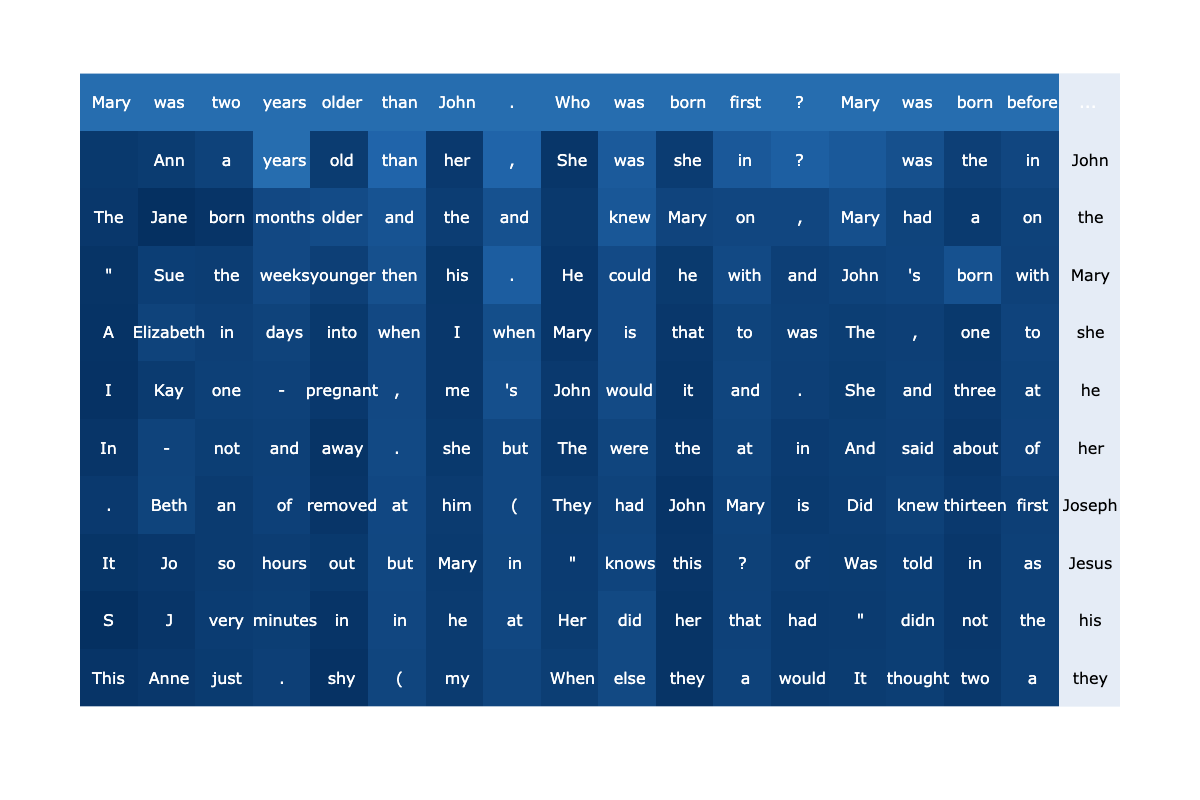

In [5]:
print_max_logits(cache, k=10)

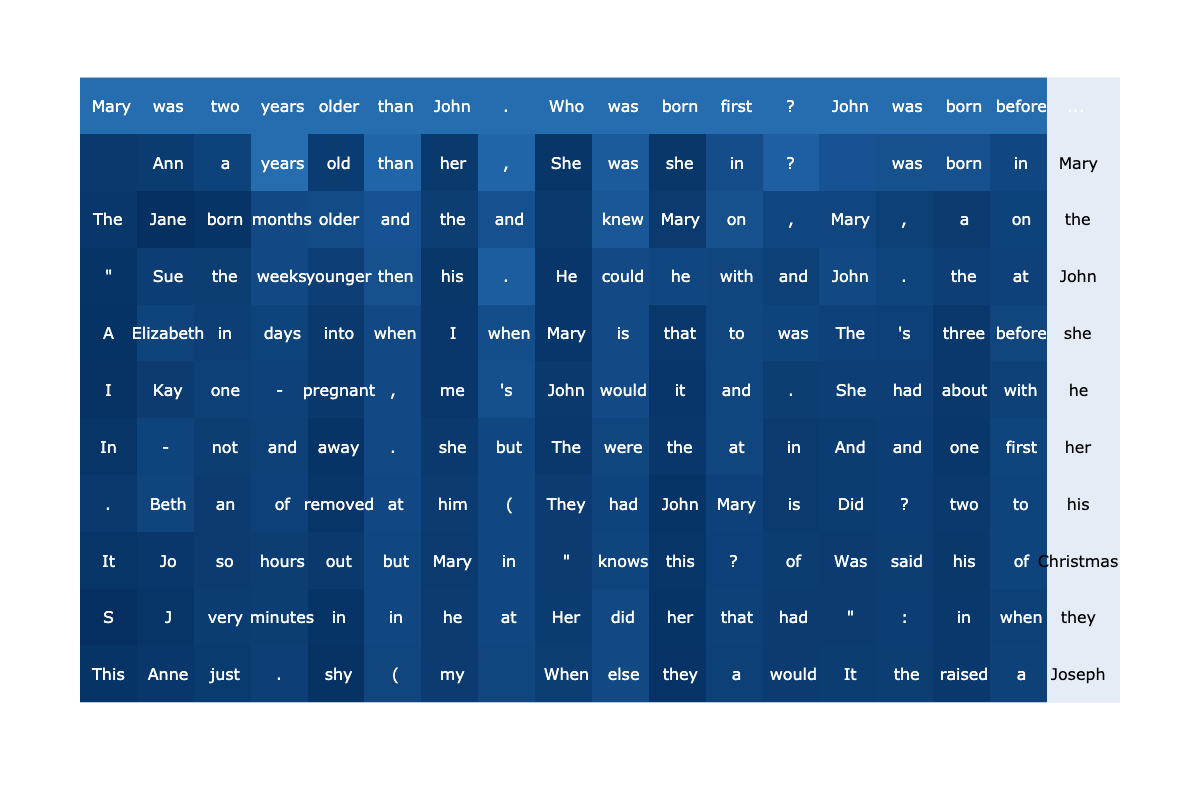

In [6]:
print_max_logits(corrupted_cache, k=10)

Interestingly, in the corrupted prompt, we see a slightly increased confidence of the false output (~10% increase).

Looking at the attention head patterns many of the top positive and negative contributors are shared, but there are a few noteable exceptions.

Tried to stack head results when they weren't cached. Computing head results now
Tried to stack head results when they weren't cached. Computing head results now


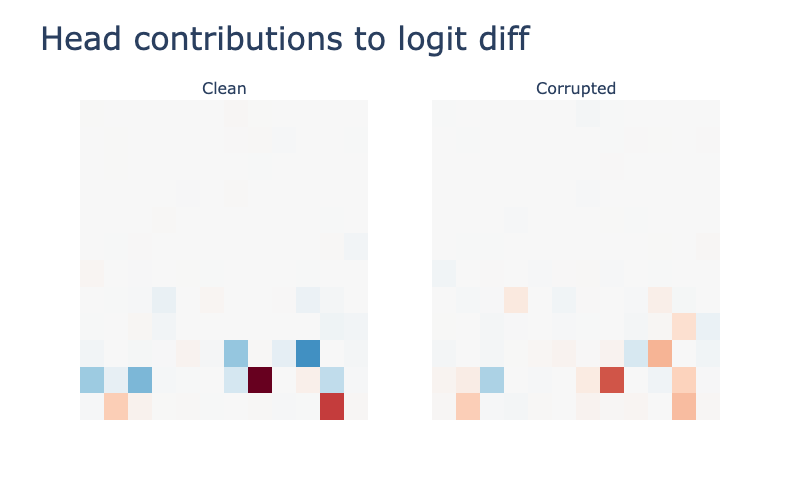

In [7]:
a = px.imshow(
    calculate_head_contribution(cache, calculate_logit_diff(cache)).cpu(),
    labels={"x": "Head", "y": "Layer"},
    color_continuous_midpoint=0.0,
    color_continuous_scale="rdbu",
)

b = px.imshow(
    calculate_head_contribution(corrupted_cache, calculate_logit_diff(corrupted_cache)).cpu(),
    labels={"x": "Head", "y": "Layer"},
    color_continuous_midpoint=0.0,
    color_continuous_scale="rdbu",
)

plot_grid((a, b), labels=["Clean", "Corrupted"], title='Head contributions to logit diff', width=800)

A couple of the top positive heads (e.g. 10.2, 9.8) are shared, but otherwise the top positive contributors for the clean inputs are the top negative contributors for the corrupted inputs (e.g. 9.9, 10.0, 10.6, etc). Many of these are name-mover heads from the IOI paper.

### Postive head patterns

We can dig into this further by looking at what those attention patterns attend to for each input.

In [8]:
labels, patterns = [], []
for head in range(144):
    layer = head // cache.model.cfg.n_heads
    head_index = head % cache.model.cfg.n_heads
    labels.append(f"L{layer}H{head_index}")
    patterns.append(cache["attn", layer][0, head_index])

patterns = torch.stack(patterns, dim=0)

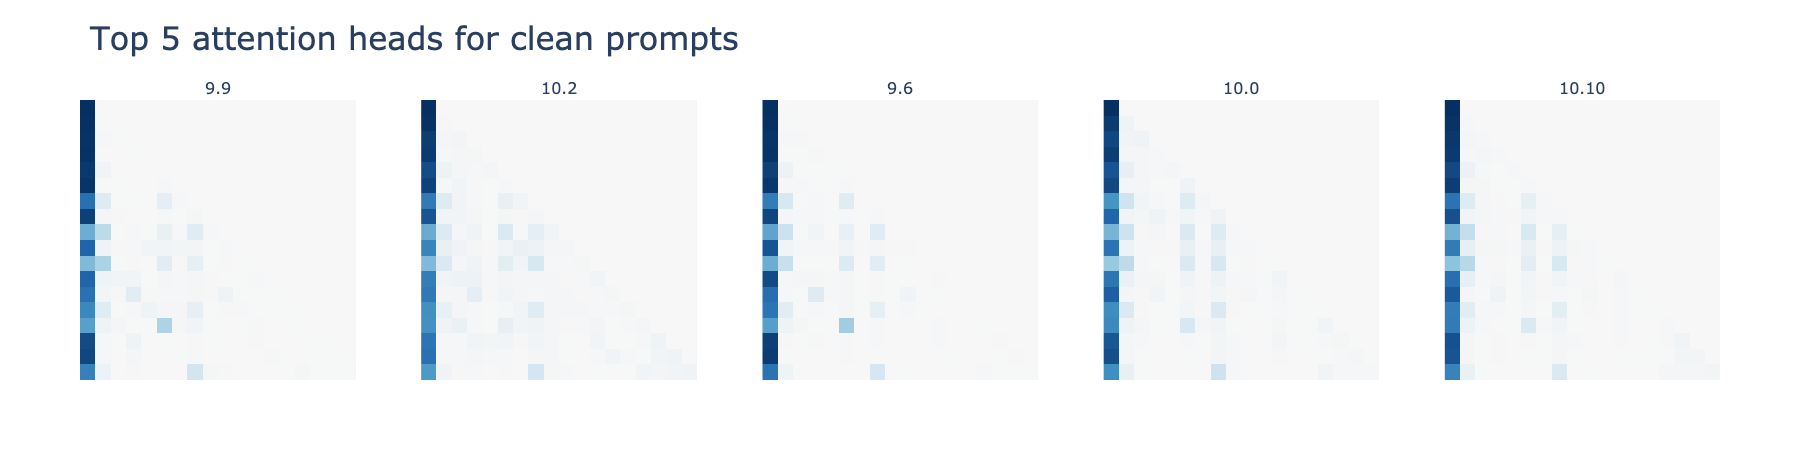

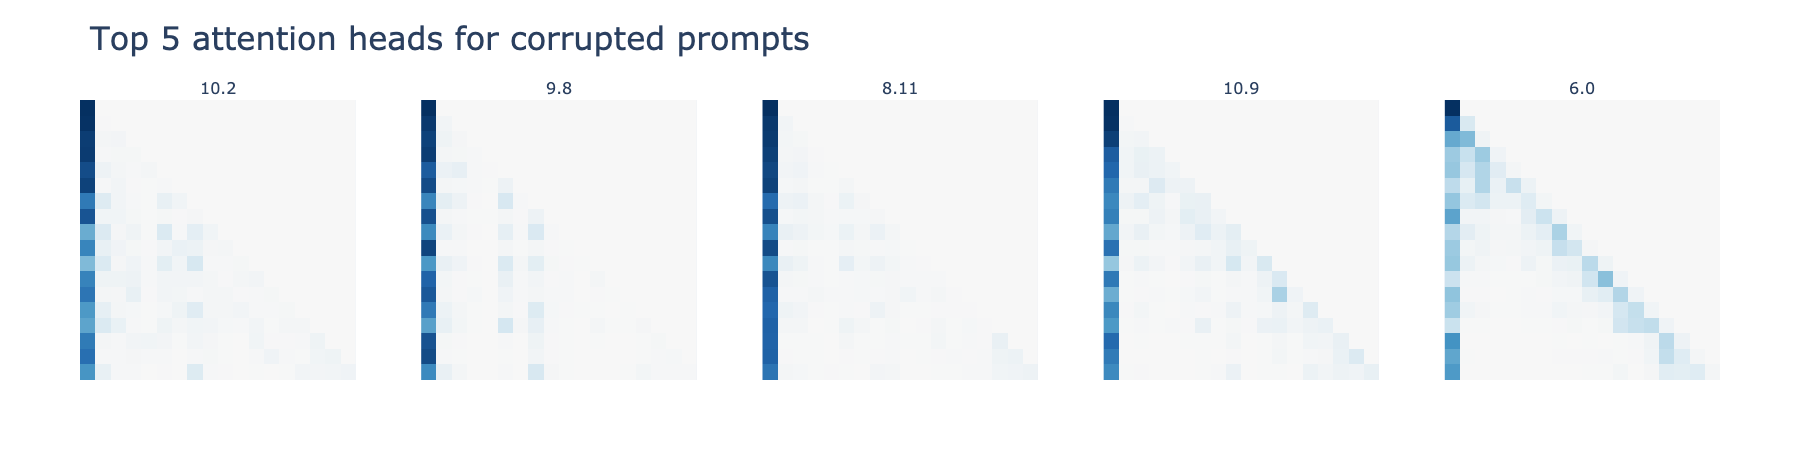

In [9]:
k = 5
logit_diff = calculate_logit_diff(cache)
per_head_logit_diffs = calculate_head_contribution(cache, logit_diff)
heads = torch.topk(per_head_logit_diffs.flatten(), k=k).indices

corrupted_logit_diff = calculate_logit_diff(corrupted_cache)
corrupted_per_head_logit_diffs = calculate_head_contribution(corrupted_cache, corrupted_logit_diff)
corrupted_heads = torch.topk(corrupted_per_head_logit_diffs.flatten(), k=k).indices

patterns = calculate_attention_patterns(cache, heads)
corrupted_patterns = calculate_attention_patterns(corrupted_cache, corrupted_heads)

figs = plot_attention_patterns(patterns)
corrupted_figs = plot_attention_patterns(corrupted_patterns)

display(plot_grid(figs, title=f'Top {k} attention heads for clean prompts'))
plot_grid(corrupted_figs, title=f'Top {k} attention heads for corrupted prompts')

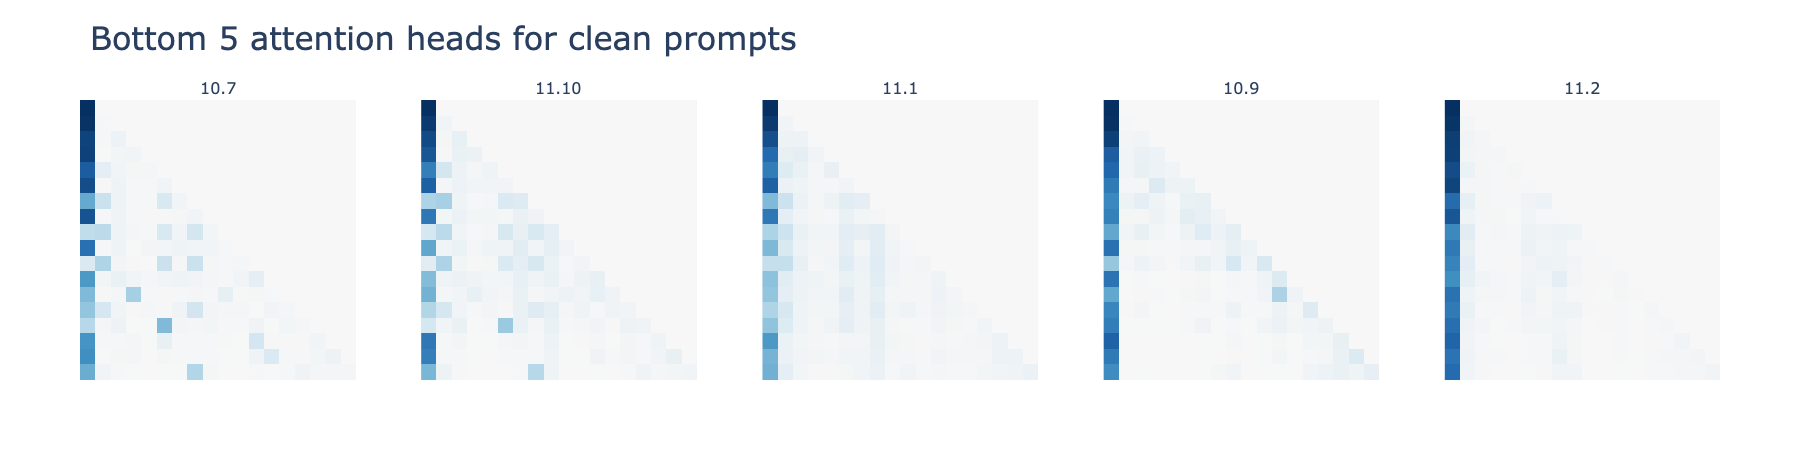

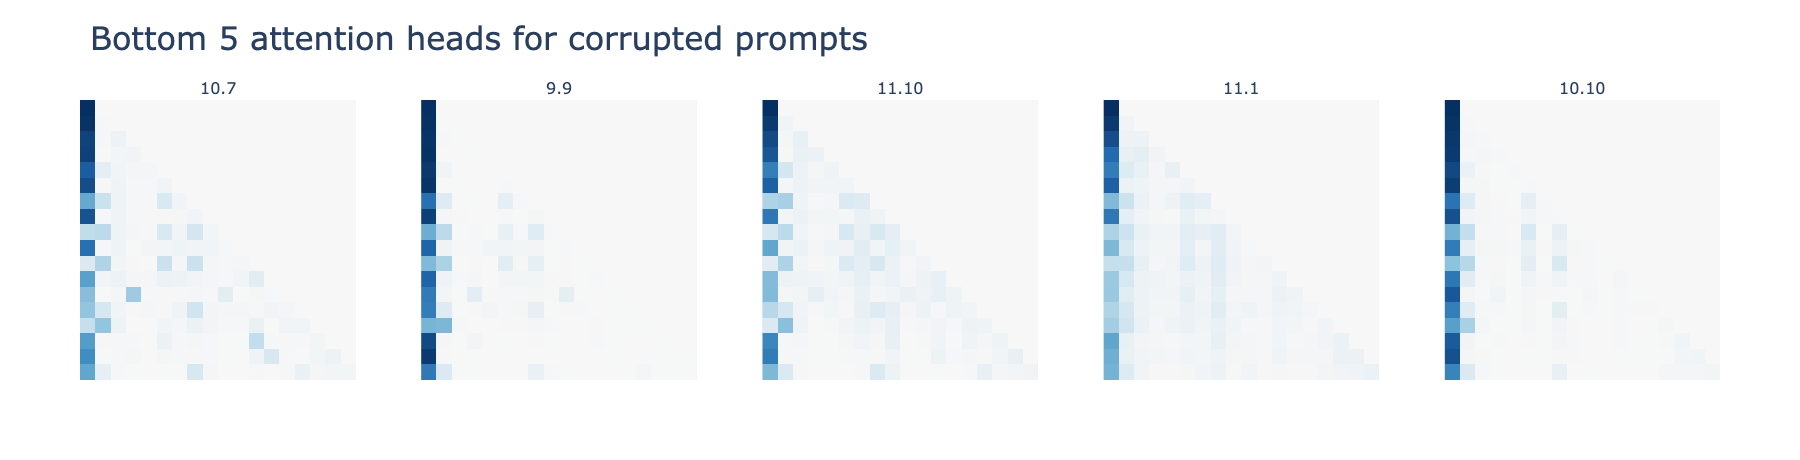

In [10]:
neg_heads = torch.topk(-per_head_logit_diffs.flatten(), k=k).indices
neg_corrupted_heads = torch.topk(-corrupted_per_head_logit_diffs.flatten(), k=k).indices

neg_patterns = calculate_attention_patterns(cache, neg_heads)
neg_corrupted_patterns = calculate_attention_patterns(corrupted_cache, neg_corrupted_heads)

neg_figs = plot_attention_patterns(neg_patterns)
neg_corrupted_figs = plot_attention_patterns(neg_corrupted_patterns)

display(plot_grid(neg_figs, title=f'Bottom {k} attention heads for clean prompts'))
plot_grid(neg_corrupted_figs, title=f'Bottom {k} attention heads for corrupted prompts')

### All heads

I find it interesting to plot the full set of heads by layer to get a sense of how they react under different inputs. Sometimes it's easier to see that there is some kind of pattern or common elements and work backwards - instead of only looking at heads that are deemed "important" using some metric like logit difference. See the pathological inputs notebook for more on this.

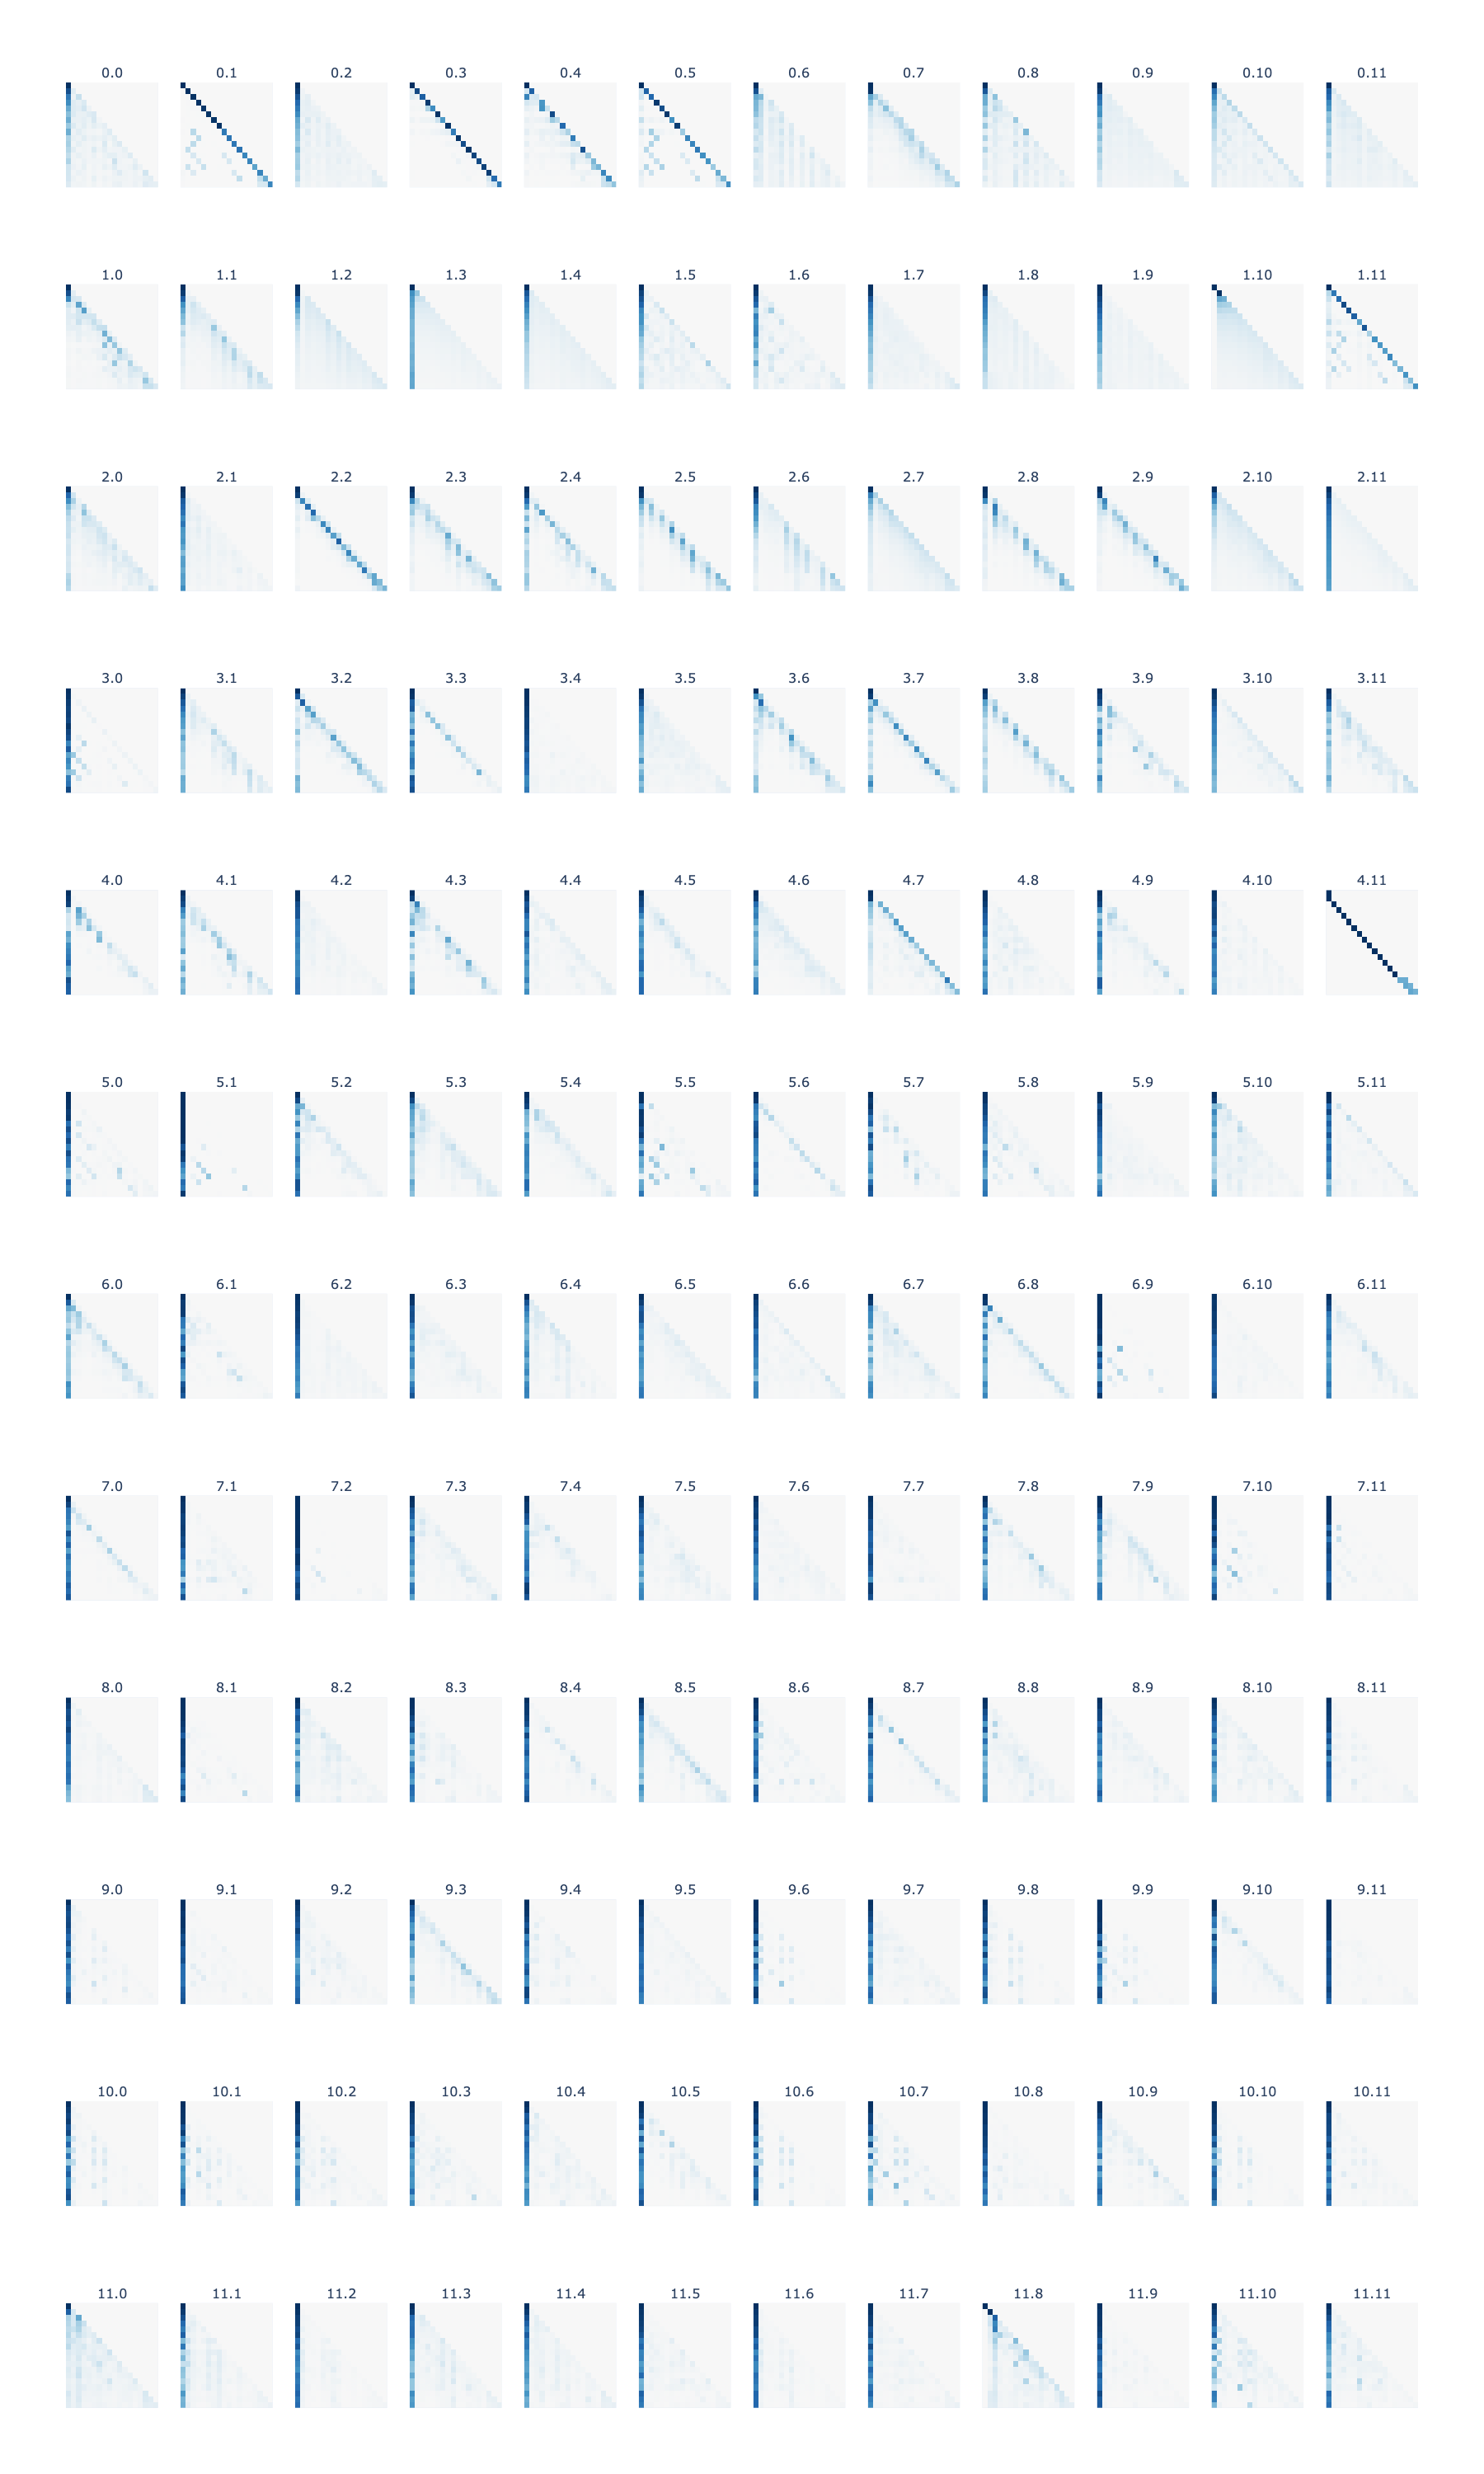

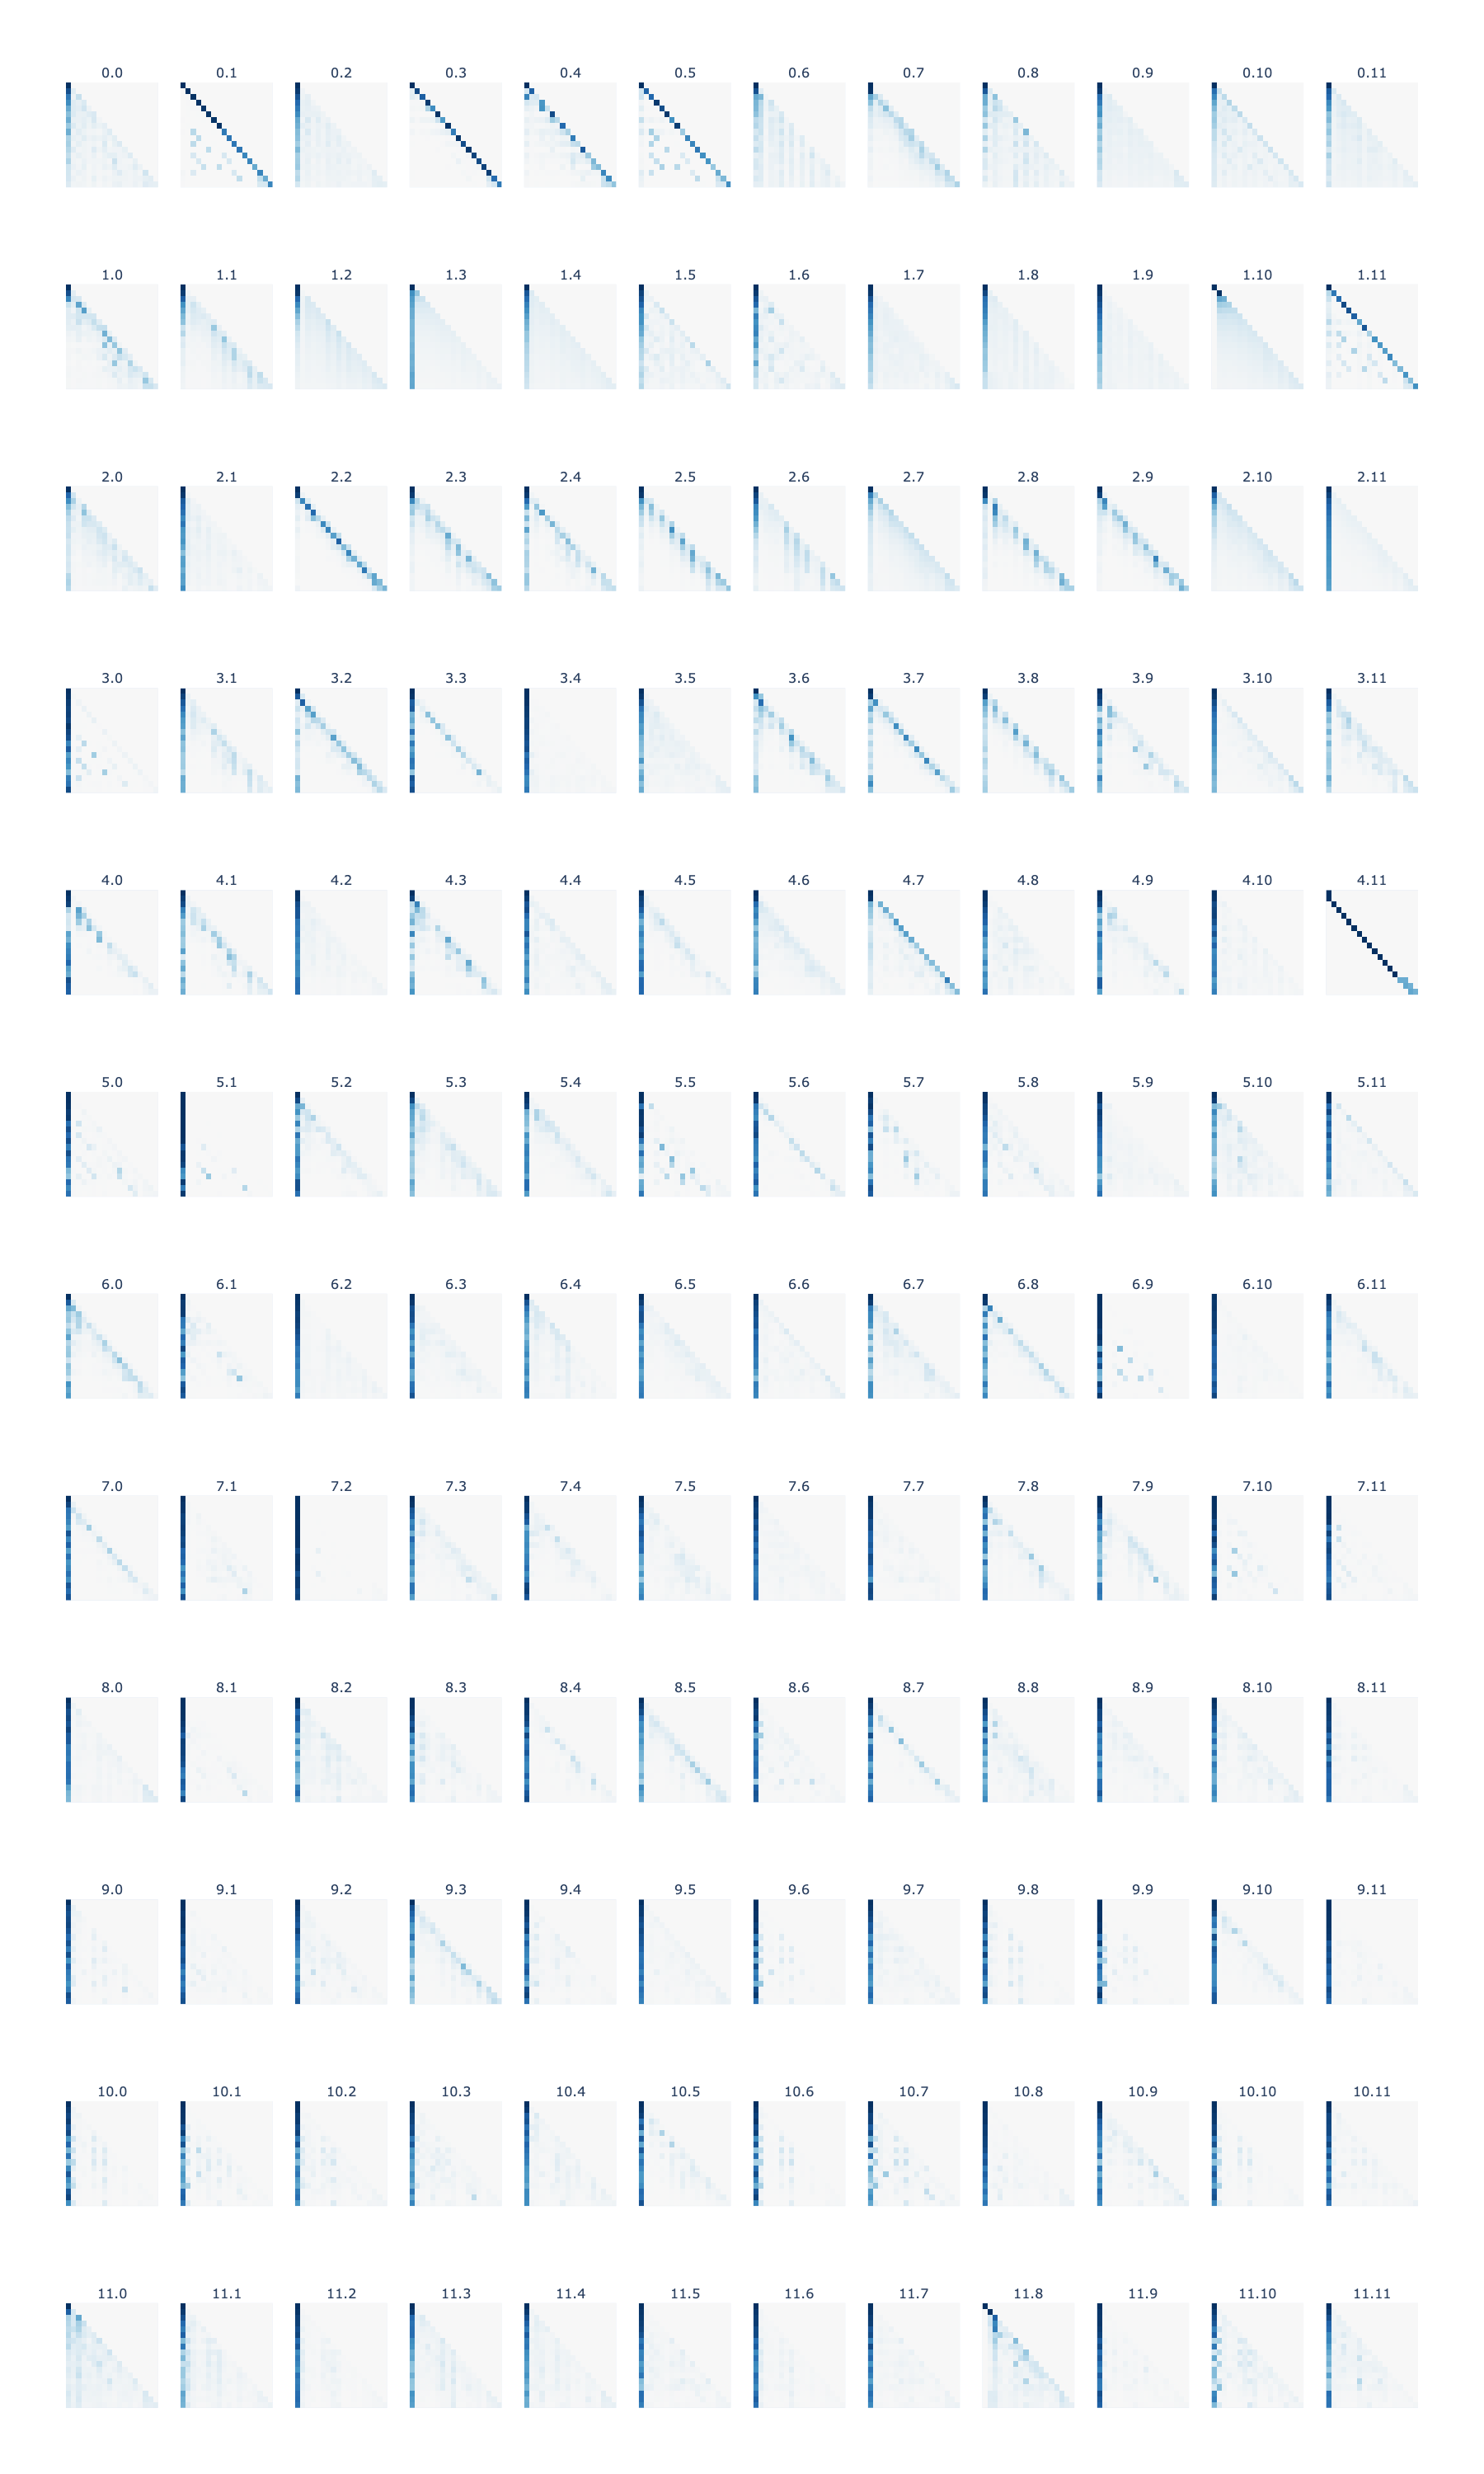

In [11]:
heads = calculate_attention_patterns(cache, range(144))
corrupted_heads = caheads = calculate_attention_patterns(corrupted_cache, range(144))

display(
    plot_grid(
        plot_attention_patterns(heads),
        rows=12,
    )
)

display(
    plot_grid(
        plot_attention_patterns(corrupted_heads),
        rows=12,
    )
)

## Activation patching

We can use activation patching to replace the output of specific components to understand how they contribute to the overall generation process. 

For example, let's try patching these heads, which demonstrate some interesting differences between the clean and corrupted inputs. 

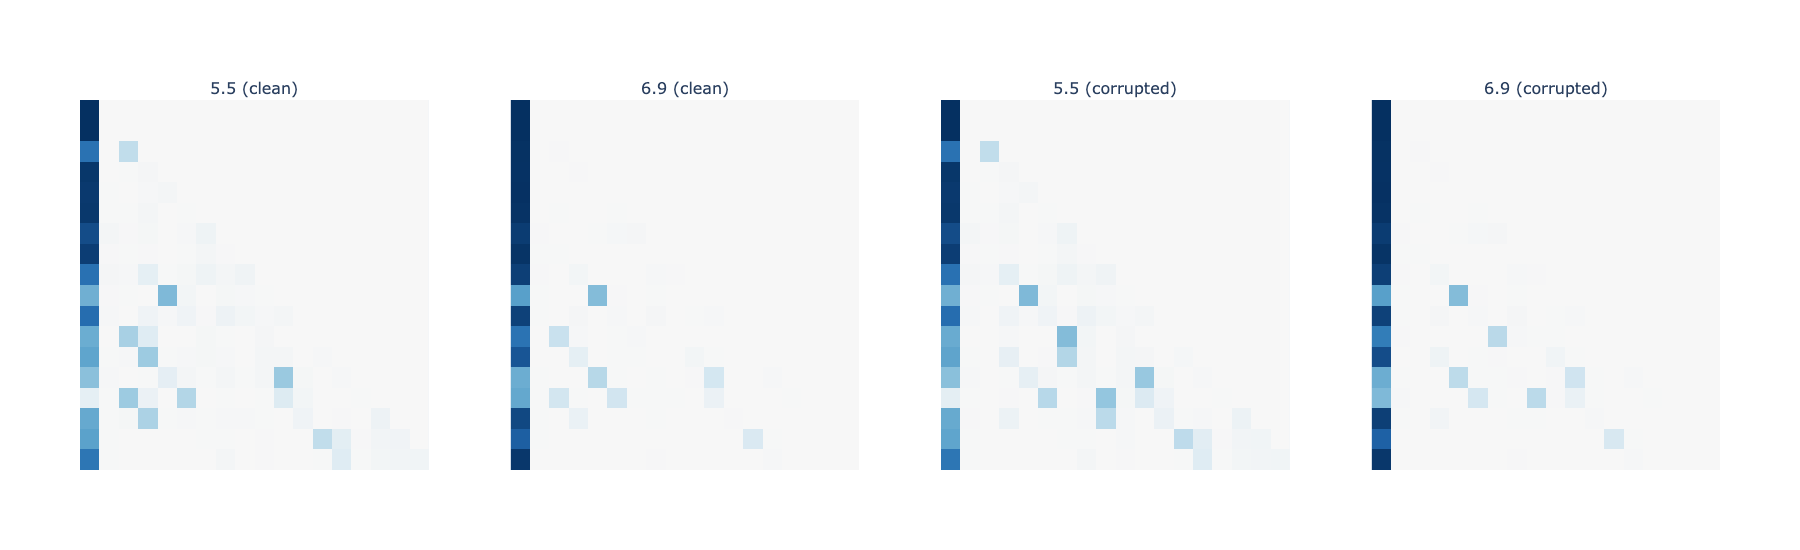

In [12]:
_, cache = model.run_with_cache([p[0] for p in prompts])
cache.prompts = prompts
_, corrupted_cache = model.run_with_cache([p[0] for p in corrupted_prompts])
corrupted_cache.prompts = corrupted_prompts

indices = [
    (5, 5),
    (6, 9),
]

indices = [ i * cache.model.cfg.n_heads + j for i, j in indices ]
heads = calculate_attention_patterns(cache, indices, component='attn')
corrupted_heads = caheads = calculate_attention_patterns(corrupted_cache, indices, component='attn')

display(
    plot_grid(
        plot_attention_patterns({
            **{f'{k} (clean)': v for k, v in heads.items()},
            **{f'{k} (corrupted)': v for k, v in corrupted_heads.items()}
        }),
    )
)

In the clean input the heads attend to specific tokens in the first sentence which correspond to the question being asked in the current sentence. In the corrupted inputs, where the model is misdirected to produce a false answer, the heads instead attend to the fullstop marking the end of the first sentence.

Swapping the Q activations at these heads between the clean and corrupted caches produces surprising attention patterns. 5.5 is reconstructed almost precisely in both directions, but 6.9 transforms to a very different pattern. However, that pattern is precisely the same in both cases.

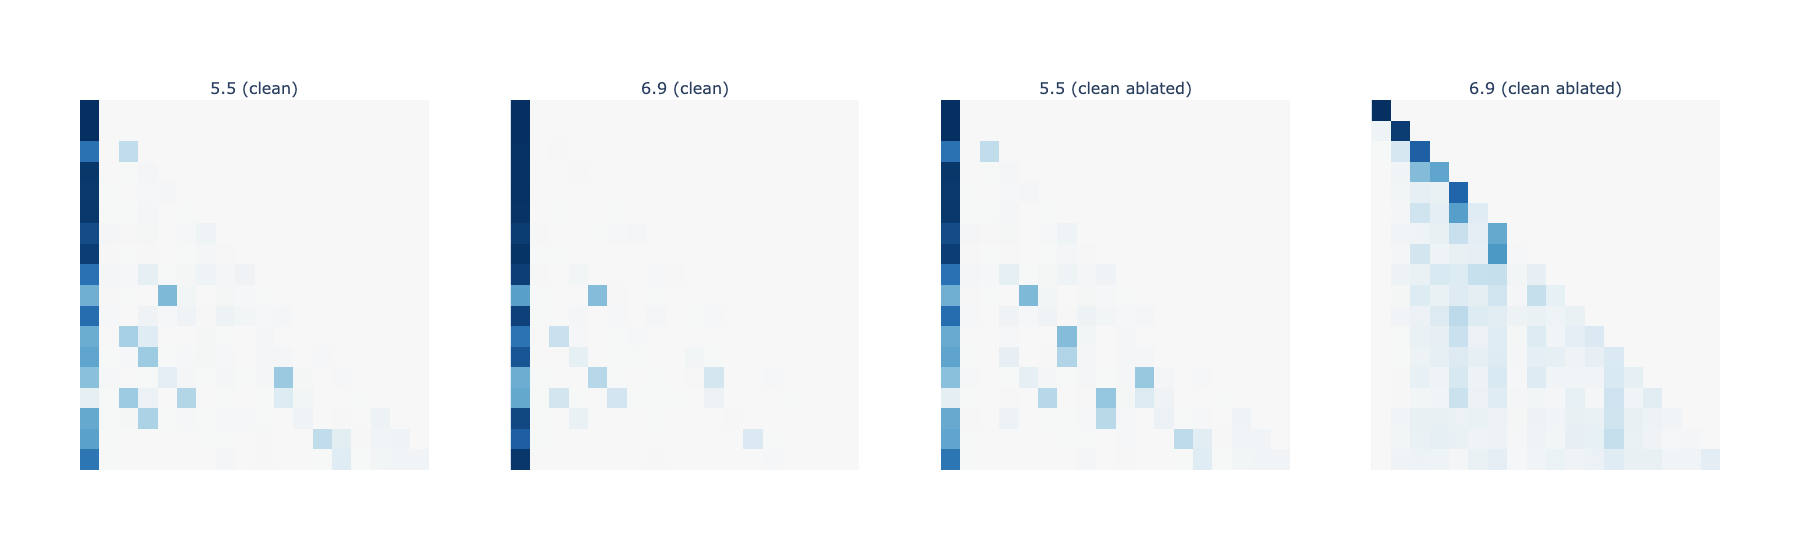

In [13]:
model.remove_all_hook_fns()
activation = 'attn.hook_q'

def swap_attention(index):
    def hook_fn(t, hook):
        t[:, :, index] = corrupted_cache[f'blocks.{index}.{activation}'][:, :, index]
    return hook_fn

model.add_hook(f'blocks.5.{activation}', swap_attention(5))
model.add_hook(f'blocks.6.{activation}', swap_attention(9))

_, ablated_cache = model.run_with_cache([p[0] for p in prompts])
ablated_cache.prompts = prompts

ablated_heads = calculate_attention_patterns(ablated_cache, indices, component='attn')

display(
    plot_grid(
        plot_attention_patterns({
            **{f'{k} (clean)': v for k, v in heads.items()},
            **{f'{k} (clean ablated)': v for k, v in ablated_heads.items()},
        }),
    )
)

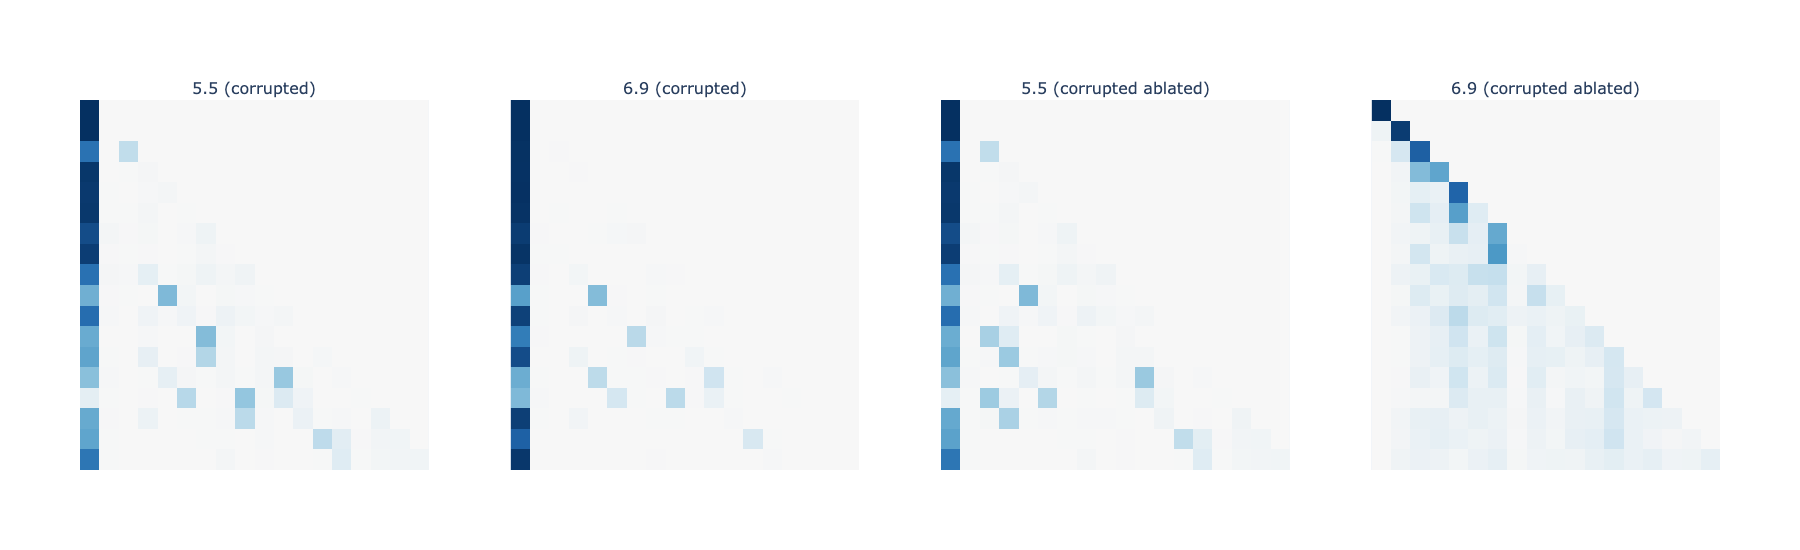

In [14]:
model.remove_all_hook_fns()
activation = 'attn.hook_q'

def swap_attention(index):
    def hook_fn(t, hook):
        t[:, :, index] = cache[f'blocks.{index}.{activation}'][:, :, index]
    return hook_fn

model.add_hook(f'blocks.5.{activation}', swap_attention(5))
model.add_hook(f'blocks.6.{activation}', swap_attention(9))

_, ablated_cache = model.run_with_cache([p[0] for p in corrupted_prompts])
ablated_cache.prompts = corrupted_prompts

ablated_heads = calculate_attention_patterns(ablated_cache, indices, component='attn')

display(
    plot_grid(
        plot_attention_patterns({
            **{f'{k} (corrupted)': v for k, v in corrupted_heads.items()},
            **{f'{k} (corrupted ablated)': v for k, v in ablated_heads.items()},
        }),
    )
)